# DHW: Jordan-Vajen
This notebook demonstrates how to use generate drinking hot-water demand time series based on the method by Jordan et. al.

Details:
Source: Jordan, U., & Vajen, K. (2005). DHWcalc: PROGRAM TO GENERATE DOMESTIC HOT WATER PROFILES WITH STATISTICAL MEANS FOR USER DEFINED CONDITIONS.
Universität Marburg.
URL: https://www.researchgate.net/publication/237651871_DHWcalc_PROGRAM_TO_GENERATE_DOMESTIC_HOT_WATER_PROFILES_WITH_STATISTICAL_MEANS_FOR_USER_DEFINED_CONDITIONS


## Imports
Import required libraries and set visualization defaults.

In [1]:
import os
import warnings

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

from entise.constants import Objects as O
from entise.constants import Types
from entise.core.generator import Generator as TSGen

warnings.filterwarnings('ignore')
%matplotlib inline

## Load Data
We load building parameters from `objects.csv` and simulation data from the `data` folder.

In [2]:
cwd = '.'  # Current working directory: change if your kernel is not running in the same folder
objects = pd.read_csv(os.path.join(cwd, 'objects.csv'))
objects['seed'] = 42  # ensure always same result
data = {}
common_data_folder = '../common_data'
for file in os.listdir(os.path.join(cwd, common_data_folder)):
    if file.endswith('.csv'):
        name = file.split('.')[0]
        data[name] = pd.read_csv(os.path.join(os.path.join(cwd, common_data_folder, file)), parse_dates=True)

print('Loaded data keys:', list(data.keys()))
print(objects)

Loaded data keys: ['validation_weather', 'weather']
   id          dhw datetimes  dwelling_size[m2]  temp_cold[C]  temp_hot[C]  \
0   1  JordanVajen   weather                100            10           60   
1   2  JordanVajen   weather                150            10           60   
2   3  JordanVajen   weather                120            10           60   
3   4  JordanVajen   weather                 80            10           60   
4   5  JordanVajen   weather                 90            10           60   
5   6  JordanVajen   weather                 80            10           60   
6   7  JordanVajen   weather                 90            10           60   
7   8  JordanVajen   weather                110            10           60   

  holidays_location  seed  
0                PT    42  
1              B,AR    42  
2               NaN    42  
3             TO,IT    42  
4                BR    42  
5             BY,DE    42  
6                MX    42  
7                NL  

## Instantiate and Configure Model
Initialize the time series generator and configure it with building objects.

In [3]:
gen = TSGen()
gen.add_objects(objects)

## Run the Simulation
Generate sequential DHW time series for each building.

In [4]:
summary, df = gen.generate(data, workers=1)

100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


## Results Summary
Below is a summary of the annual volume (l), energy (Wh) and power demands (W).

In [5]:
print("Summary:")
print(summary)

Summary:
   dhw:volume_total[l]  dhw:volume_avg[l]  dhw:volume_peak[l]  \
1                20932              2.389             260.292   
2                23915              2.730             249.391   
3                21530              2.458             159.896   
4                18346              2.094             148.656   
5                20639              2.356             148.080   
6                18346              2.094             148.236   
7                20639              2.356             148.080   
8                23025              2.628             182.962   

   dhw:energy_total[Wh]  dhw:energy_avg[Wh]  dhw:energy_peak[Wh]  \
1                973563                 111                12106   
2               1112338                 127                11599   
3               1001388                 114                 7437   
4                853275                  97                 6914   
5                959963                 110                 6887 

## Visualization of Results

Visualization of the volume and energy demand per time step for all eight buildings.

In [6]:
def plot_dhw_demand(ax, obj_id, df, title):
    obj_data = df[obj_id][Types.DHW]
    obj_data.index = pd.to_datetime(obj_data.index)

    # Plot volume
    ax.plot(obj_data.index, obj_data[f"{Types.DHW}:volume[l]"], label="DHW Volume (liters)", color="blue")
    ax.set_ylabel("Volume (liters)")
    ax.set_title(title)
    ax.legend(loc="upper left")
    ax.grid(True)

    # Add second y-axis for energy
    ax_energy = ax.twinx()
    ax_energy.plot(obj_data.index, obj_data[f"{Types.DHW}:energy[Wh]"], label="DHW Energy (Wh)", color="red", alpha=0.7)
    ax_energy.set_ylabel("Energy (Wh)")
    ax_energy.legend(loc="upper right")

    # Format x-axis for better readability
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))  # Show every 7 days

    return obj_data

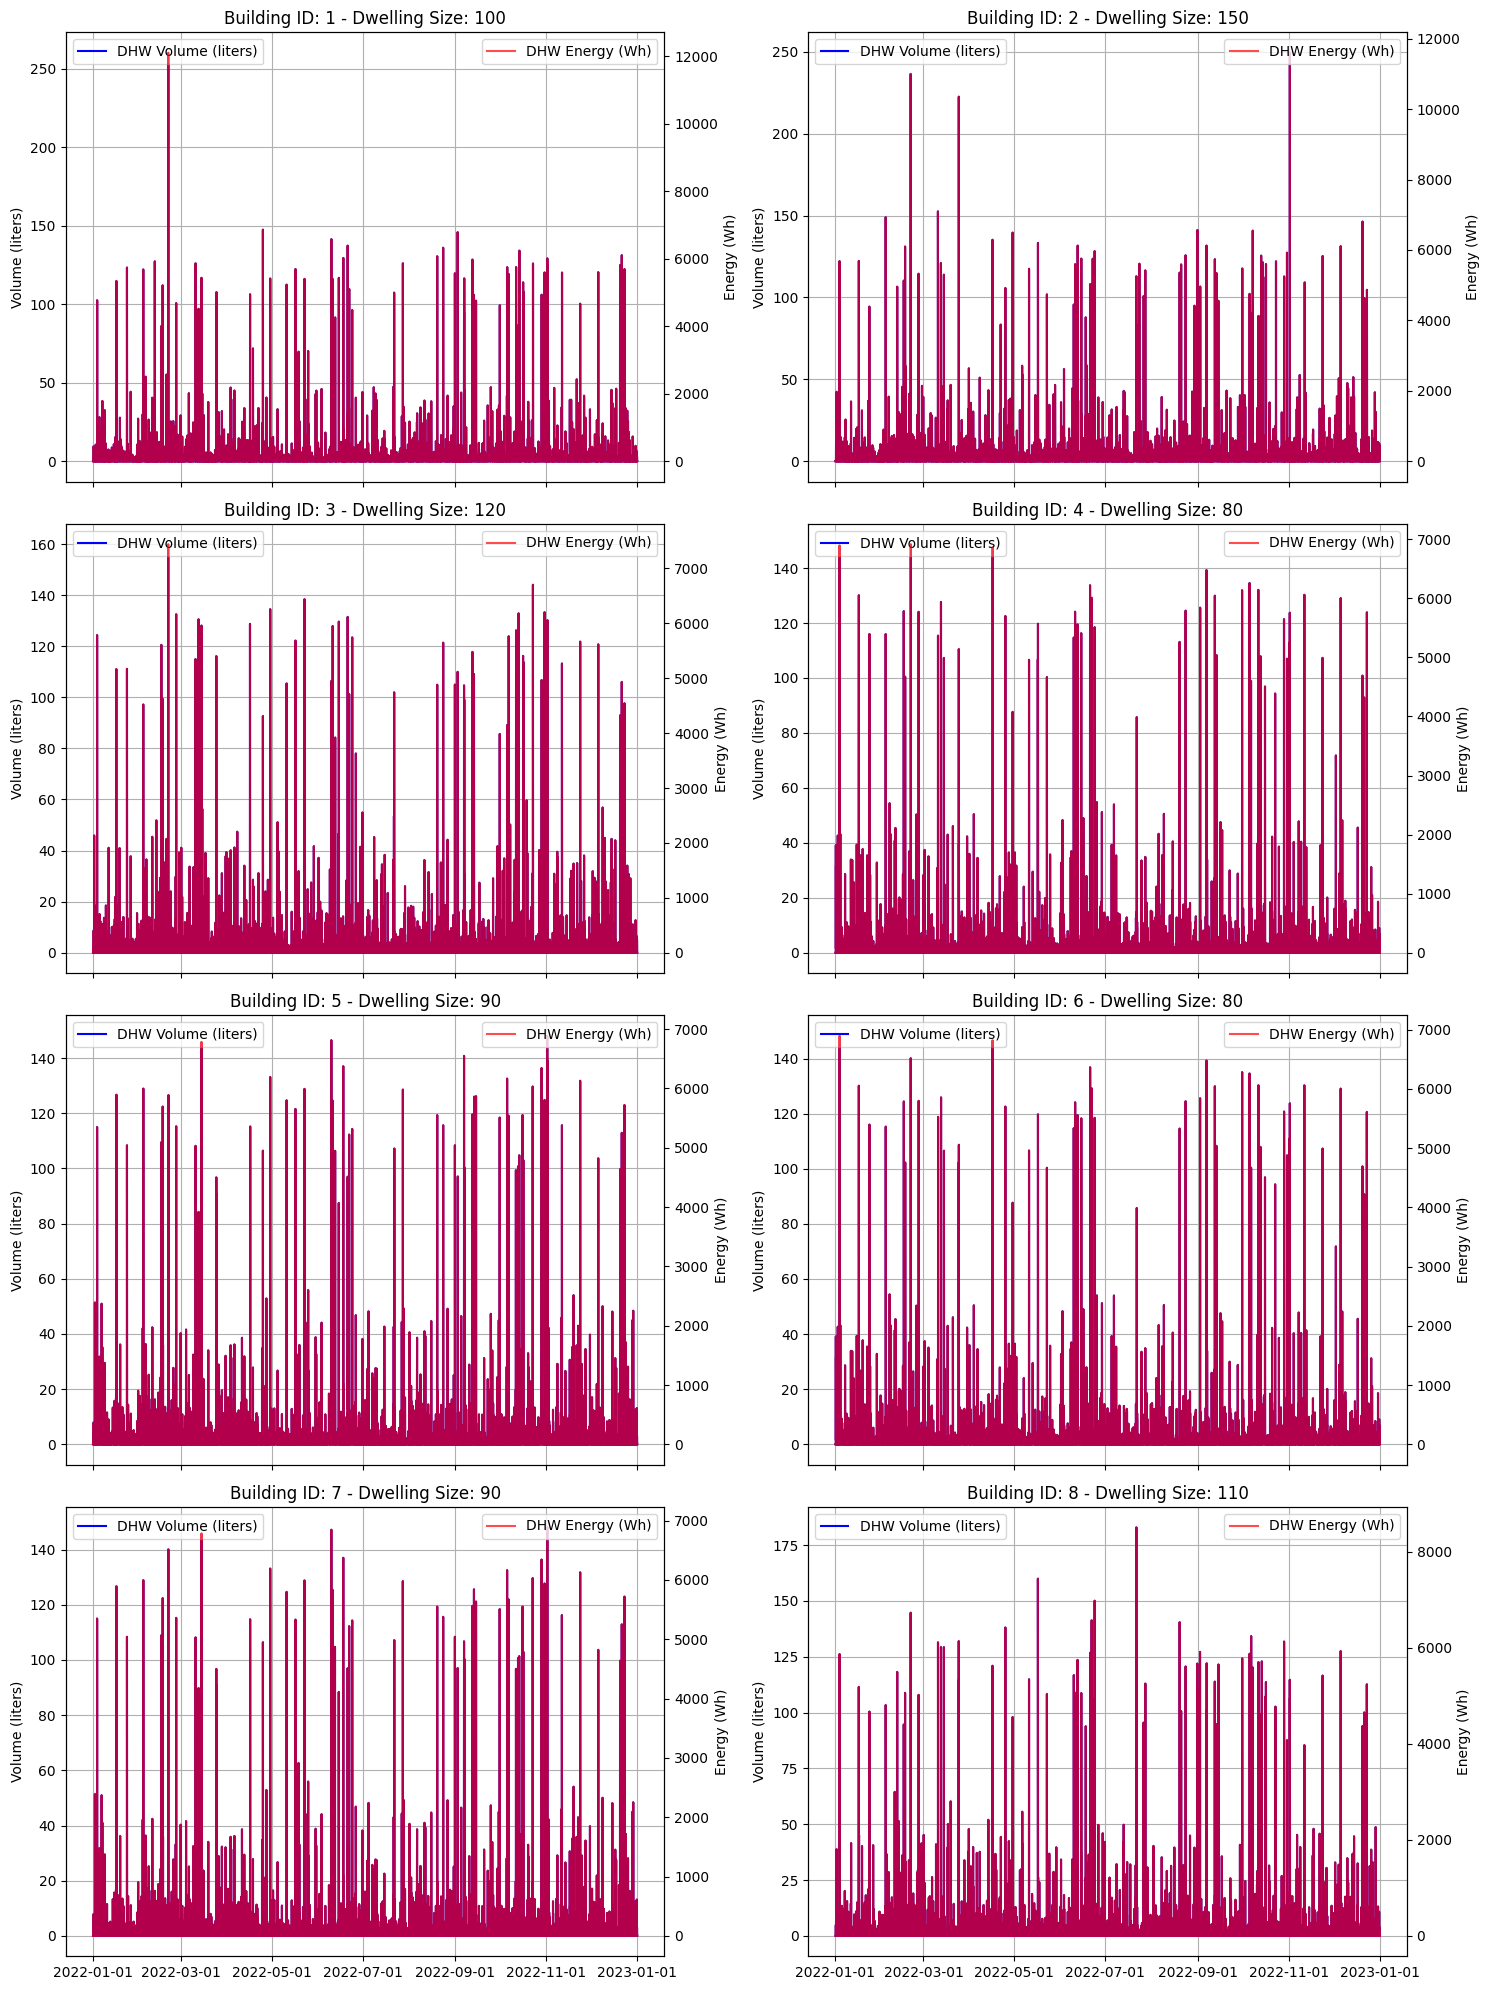

In [7]:
# Figure setup
fig, axes = plt.subplots(4, 2, figsize=(15, 20), sharex=True)
axes = axes.flatten()

# Plot each object
objects.set_index("id", inplace=True)
for i, (obj_id, object) in enumerate(objects.iterrows()):
    plot_dhw_demand(axes[i], obj_id, df, f"Building ID: {obj_id} - Dwelling Size: {object[O.DWELLING_SIZE]}")

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.tight_layout()
plt.show()

Visualization of the average daily dhw demand for each building.

In [8]:
def plot_daily_profile(ax, obj_data, title):
    obj_data["hour"] = obj_data.index.hour
    daily_profile = obj_data.groupby("hour")[f"{Types.DHW}:volume[l]"].mean()
    ax.bar(daily_profile.index, daily_profile.values, color="skyblue", alpha=0.7)
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Average DHW Volume (liters)")
    ax.set_title(title)
    ax.set_xticks(range(0, 24, 2))
    ax.grid(True, alpha=0.3)

    # Calculate yearly total in m3
    yearly_total = obj_data[f"{Types.DHW}:volume[l]"].sum() / 1000  # Convert L to m3
    ax.text(
        0.95,
        0.95,
        f"Yearly total: {yearly_total:.1f} m³",
        transform=ax.transAxes,
        horizontalalignment="right",
        verticalalignment="top",
        bbox=dict(facecolor="white", alpha=0.8),
    )

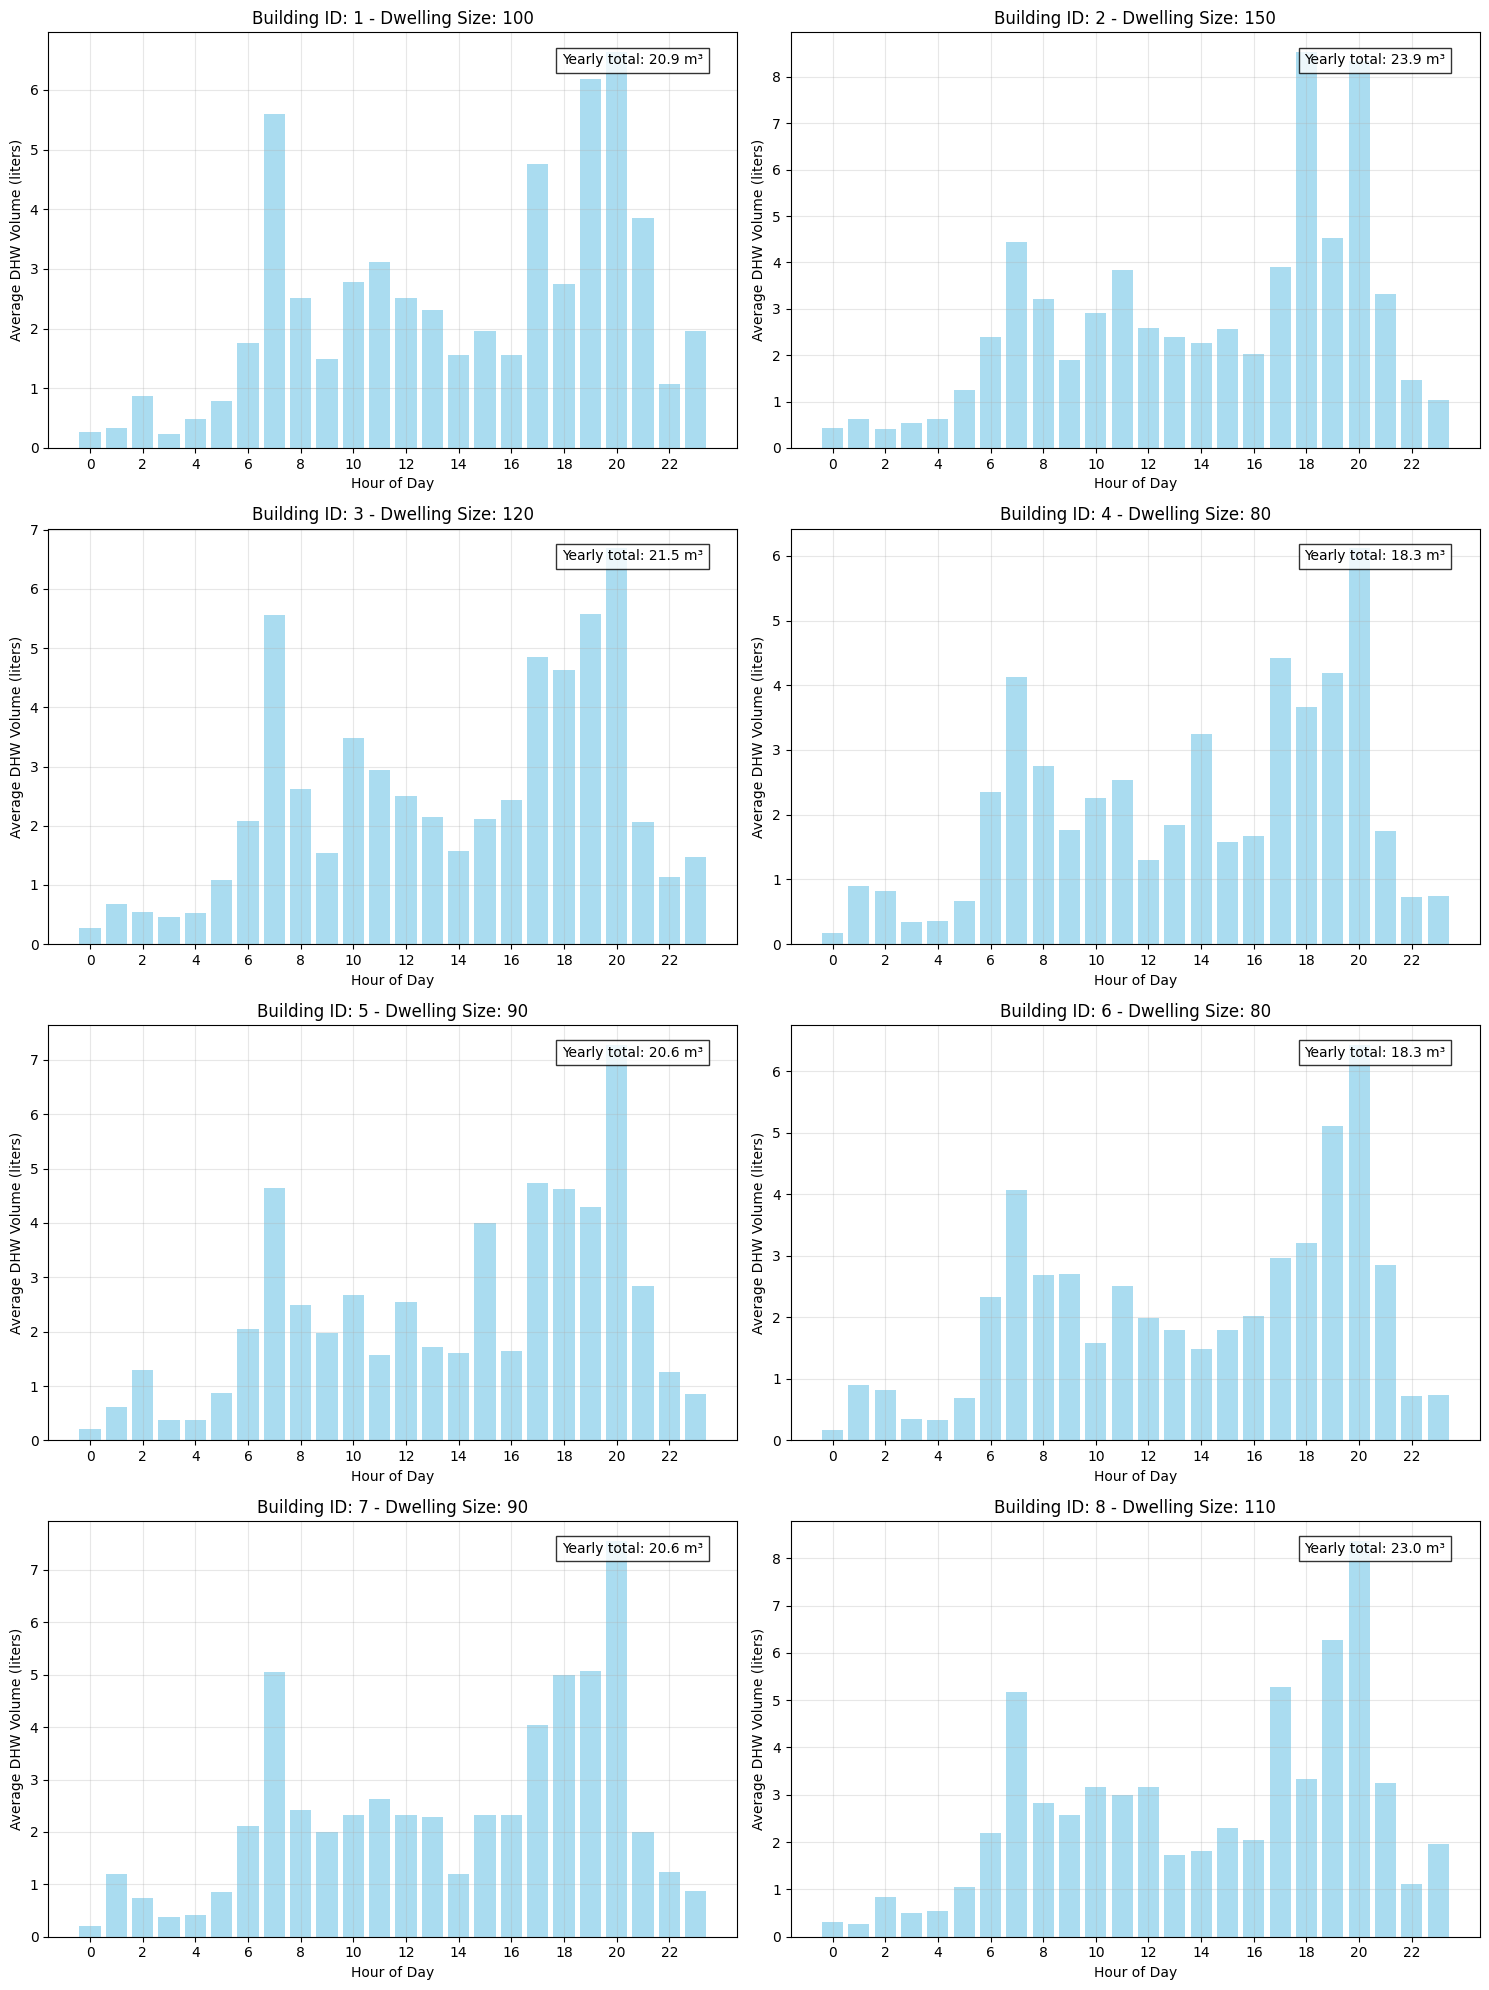

In [9]:
# Figure setup
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()

# Plot daily profiles for each object
for i, (obj_id, object) in enumerate(objects.iterrows()):
    plot_daily_profile(
        axes[i], df[obj_id][Types.DHW], f"Building ID: {obj_id} - Dwelling Size: {object[O.DWELLING_SIZE]}"
    )

plt.tight_layout()
plt.show()

Visualization of the average daily dhw demand for building 6 split into weekday and weekend demand.


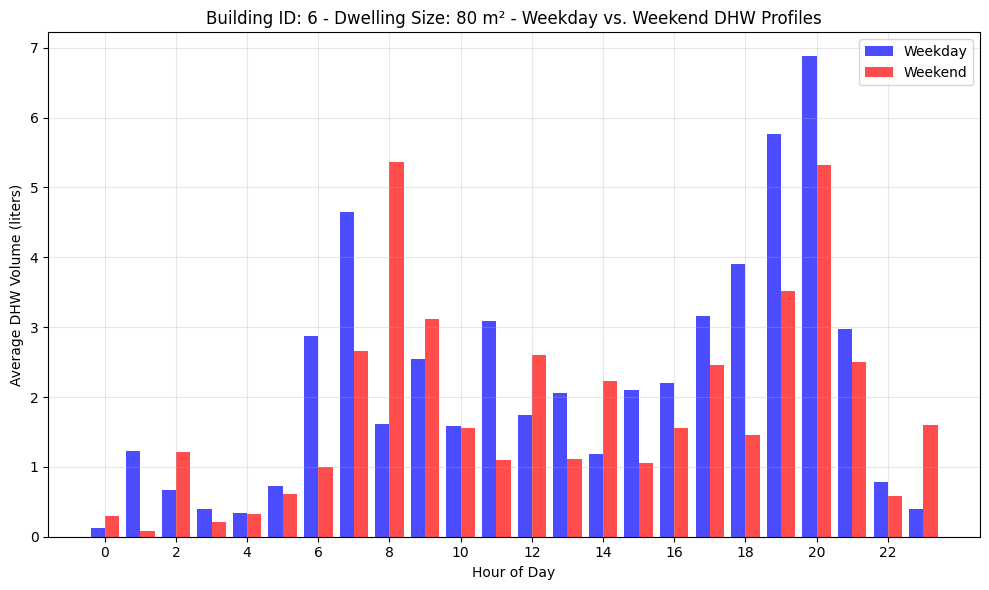

In [10]:
# Compare weekend vs. weekday profiles for object 6 (with weekend activity)
fig, ax = plt.subplots(figsize=(10, 6))

# Extract weekday and weekend data
obj6_data = df[6][Types.DHW]
obj6_data["day_of_week"] = obj6_data.index.dayofweek
weekday_data = obj6_data[obj6_data["day_of_week"] < 5]  # Monday-Friday
weekend_data = obj6_data[obj6_data["day_of_week"] >= 5]  # Saturday-Sunday

# Calculate average profiles
weekday_profile = weekday_data.groupby("hour")[f"{Types.DHW}:volume[l]"].mean()
weekend_profile = weekend_data.groupby("hour")[f"{Types.DHW}:volume[l]"].mean()

# Plot both profiles
ax.bar(weekday_profile.index - 0.2, weekday_profile.values, width=0.4, color="blue", alpha=0.7, label="Weekday")
ax.bar(weekend_profile.index + 0.2, weekend_profile.values, width=0.4, color="red", alpha=0.7, label="Weekend")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Average DHW Volume (liters)")
ax.set_title("Building ID: 6 - Dwelling Size: 80 m² - Weekday vs. Weekend DHW Profiles")
ax.set_xticks(range(0, 24, 2))
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## Next Steps
You can further explore:
- Adjusting building parameters in `objects.csv`
- Incorporating or excluding additional data (e.g. holidays)
- Automating analysis for larger building datasets